# **Decision Trees (from scratch)**

This tutorial will guide you through the implementation of decision trees in Python. While scikit-learn is a useful tool for utilizing decision trees, it is largely a black box that does not help you gain a deeper understanding of the concepts covered in the lecture.

Therefore, we will ues only NumPy in the first part of this tutorial. By building decision trees from scratch, you will have a better understanding of the concepts behind them and how they are built.

Let's first import some libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

# **Dataset**
We will use the well-known [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) for this tutorial. The dataset includes 50 samples from each of three species of Iris (Iris setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample, i.e. the length and width of the sepals and petals in centimeters.

To make the input space easier to plot, we will only consider two features (i.e. petal length and width).

Let's load and print the data:

In [ ]:
iris = load_iris()
iris_df = pd.DataFrame(
    data=np.c_[iris["data"], iris["target"]],
    columns=iris["feature_names"] + ["target"]
)

# Select only 2 features
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]

iris_df.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0


We now convert the data into NumPy variables:

In [ ]:
X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy().ravel().astype(np.int32)

We also define a function that plots the data:

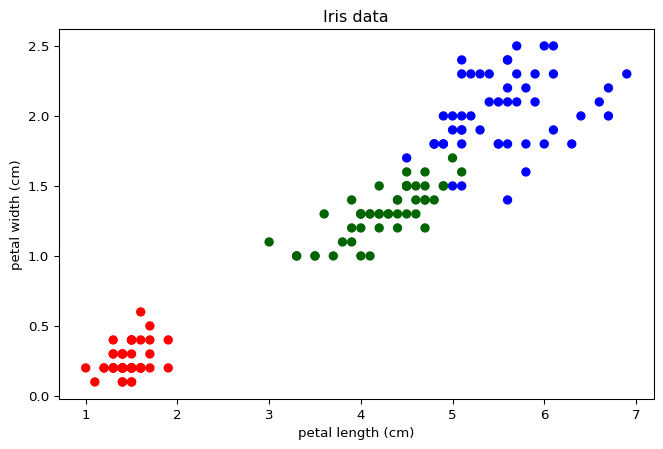

In [ ]:
def plot_data(
    X, y, model=None, plot_boundaries=False,
    xlabel="petal length (cm)", ylabel="petal width (cm)",
    title="Iris data",
):

    # Hyperparameter for mesh grid
    X1_min = X[:, 0].min() - 0.5
    X1_max = X[:, 0].max() + 0.5
    X2_min = X[:, 1].min() - 0.5
    X2_max = X[:, 1].max() + 0.5
    step = 0.01

    xx1, xx2 = np.meshgrid(
        np.arange(X1_min, X1_max, step),
        np.arange(X2_min, X2_max, step),
    )
    if plot_boundaries:
        z = model.predict(np.column_stack([xx1.ravel(), xx2.ravel()]))
        z = z.reshape(xx1.shape)

    # Create color maps for 3 classes
    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    cmap_bold = ListedColormap(["#FF0000", "#006400", "#0000FF"])

    plt.figure(figsize=(8, 5), dpi=96)

    if plot_boundaries:
        plt.pcolormesh(xx1, xx2, z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot_data(X, y)

## **Decision Trees**

Decision trees are **non-parameteric** machine learning models that make predictions based on nested if-then-else statements, whose structure is learned directly from the training data. They are characterized by the following properties:

* **Small** decision trees are **interpretable**
* **Inference is fast**: each if-then-else test is simple and each prediction follows only one path in the tree
* They are **flexible**: multi-class classification is straightforward, and categorical and missing features are easy to handle
* They **work well in practice** despite their simplicity and they are the basis of several state-of-the-art methods for tabular data, including Random Forests.

Although we can build decision trees both for classification and regression, **in this tutorial we will focus on classification trees**. In particular, we will implement a decision tree classifier from scratch using NumPy.
We will use **binary trees**, **Gini index** as an impurity metric, and the **max impurity decrease** heuristic for selecting features and corresponding thresholds.

A **recursive** algorithm exists to elegantly build such a classification tree from the training data:

1. Assign each training sample $i \in \{1, \dots, N\}$  to the root node of the tree and set current node to the root node;
2. Identify feature $j^* \in \{1, \dots, M\}$ and the corresponding threshold value $\tau_{j^*}$ (selected among the unique values taken by this feature) that results in the max impurity decrease and set this feature as the splitting criterion for the current node;
3. **Case 1**: the max impurity decrease is 0 $=>$ tag the current node as a leaf and return; <br> **Case 2**: the max impurity decrease is greater than 0 $=>$ partition all samples into 2 groups according to the splitting criterion (**left** if feature $j^*$ value $\le \tau_{j^*}$, **right** otherwise) and build the corresponding child nodes (**left child** and **right child**) for the current node. <br>
Then, for each child node, if it is pure, tag it as a leaf and return, otherwise set it as the current node and **recurse to step 2**.

At inference time, we traverse the tree based on the feature values of the given test sample until we reach a leaf node. The predicted label is the one with max frequency among those that were assigned to such a leaf node when the tree was built.

Let's start with defining a function that computes the **Gini index**:

In [ ]:
def compute_gini(y):
    # counts[i] = number of samples with label i
    counts = np.bincount(y)

    # Normalize to obtain probabilities
    probs = counts / len(y)

    # Compute Gini index
    gini = (1 - np.sum(probs ** 2)) / 2

    return gini

Let's define a function that computes the most frequent label in an array and a function that splits a batch of samples based on the given feature and its corresponding threshold:

In [ ]:
def get_most_frequent_label(y):
    return np.argmax(np.bincount(y))


def split(X_column, split_threshold):
    mask = (X_column <= split_threshold)
    left_idxes = np.argwhere(mask).flatten()
    right_idxes = np.argwhere(~mask).flatten()
    return left_idxes, right_idxes

Let's define a function that computes the **impurity decrease**:

In [ ]:
def compute_impurity_decrease(y, X_column, split_threshold):
    parent_impurity = compute_gini(y)

    left_idxes, right_idxes = split(X_column, split_threshold)

    # Check whether no split was performed
    if len(left_idxes) == 0 or len(right_idxes) == 0:
        return 0.

    num_samples = len(y)
    num_samples_left = len(left_idxes)
    num_samples_right = len(right_idxes)

    left_impurity = compute_gini(y[left_idxes])
    right_impurity = compute_gini(y[right_idxes])

    # Weighted sum of left and right child
    child_impurity = (
      (num_samples_left / num_samples) * left_impurity
      + (num_samples_right / num_samples) * right_impurity
    )

    impurity_decrease = parent_impurity - child_impurity
    return impurity_decrease

Let's define a **node**:

In [ ]:
class Node:
    def __init__(
        self, feature_idx=None, threshold=None,
        left_node=None, right_node=None, label=None,
    ):
        # Index of feature used for splitting
        self.feature_idx = feature_idx

        # Threshold value for splitting
        self.threshold = threshold

        # Left node
        self.left_node = left_node

        # Right node
        self.right_node = right_node

        self.label = label

        # It is a leaf if it contains a label
        self.is_leaf_node = label is not None

We now have all the ingredients to define our **decision tree classifier**:

In [ ]:
class MyDecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=None, max_features=None):
        # Min number of samples in a node to allow for splitting
        self.min_samples_split = min_samples_split

        # Max tree depth
        if max_depth is None:
            max_depth = float("inf")
        self.max_depth = max_depth

        # If max_features < X.shape[1] then choose features randomly
        self.max_features = max_features

        self.root = None

    def fit(self, X, y):
        # Avoid situations when max_features > number of actual features
        if self.max_features is None:
            self.max_features = X.shape[1]
        else:
            self.max_features = min(self.max_features, X.shape[1])

        self.root = self._build_node(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _best_split(self, X, y, feature_idxes):
        max_impurity_decrease = -1

        best_idx, best_threshold = None, None

        # Iterate over features
        for idx in feature_idxes:
            # Take all values for this feature
            X_column = X[:, idx]

            # Consider only the unique values for this feature
            thresholds = np.unique(X_column)

            # For each unique value
            for threshold in thresholds:
                impurity_decrease = compute_impurity_decrease(y, X_column, threshold)
                # Save impurity decrease if better
                if impurity_decrease > max_impurity_decrease:
                    max_impurity_decrease = impurity_decrease
                    best_idx = idx
                    best_threshold = threshold
        return best_idx, best_threshold

    def _build_node(self, X, y, depth=0):
        num_samples, num_features = X.shape

        # Array of unique classes
        num_labels = len(np.unique(y))

        # Check stopping criteria (max_depth and min_samples_split)
        if (
            depth >= self.max_depth
            or num_labels == 1
            or num_samples < self.min_samples_split
            or len(np.unique(X)) == X.shape[1]  # Handle mislabeled samples (same features but different labels)
        ):
            # Leaf node
            label = get_most_frequent_label(y)
            return Node(label=label)

        # If max_features < number of features, select a random subset of features,
        # otherwise select all features
        feature_idxes = np.random.choice(num_features, self.max_features, replace=False)

        best_feature_idx, best_threshold = self._best_split(X, y, feature_idxes)
        left_idxes, right_idxes = split(X[:, best_feature_idx], best_threshold)

        # After finding the best split, we assign
        # left and right data to the child nodes
        left = self._build_node(X[left_idxes, :], y[left_idxes], depth + 1)
        right = self._build_node(X[right_idxes, :], y[right_idxes], depth + 1)

        return Node(best_feature_idx, best_threshold, left, right)

    def _traverse_tree(self, x, node):
        # If current node is a leaf then return its label
        # (i.e. the label with max frequency)
        if node.is_leaf_node:
            return node.label

        # Check feature in this node and compare
        # node threshold with feature value in x
        if x[node.feature_idx] <= node.threshold:
            # Send x to child node until it reaches a leaf node
            return self._traverse_tree(x, node.left_node)
        else:
            return self._traverse_tree(x, node.right_node)

Now we can train the decision tree classifier and plot the decision boundaries:

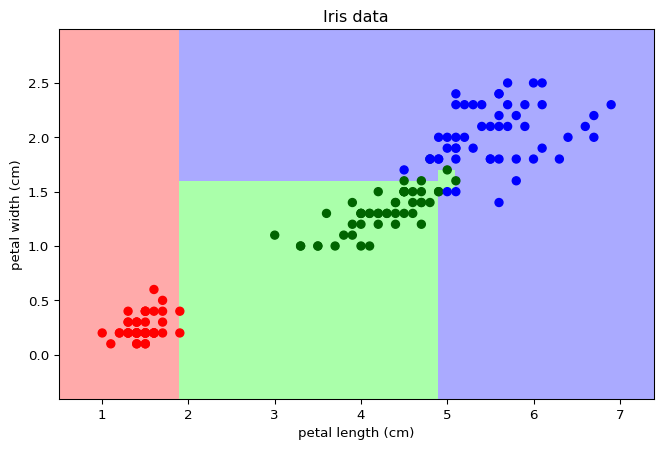

In [ ]:
my_tree = MyDecisionTreeClassifier(min_samples_split=2, max_depth=10)
my_tree.fit(X, y)
plot_data(X, y, model=my_tree, plot_boundaries=True)

Let's compare it with the model learned by scikit-learn:

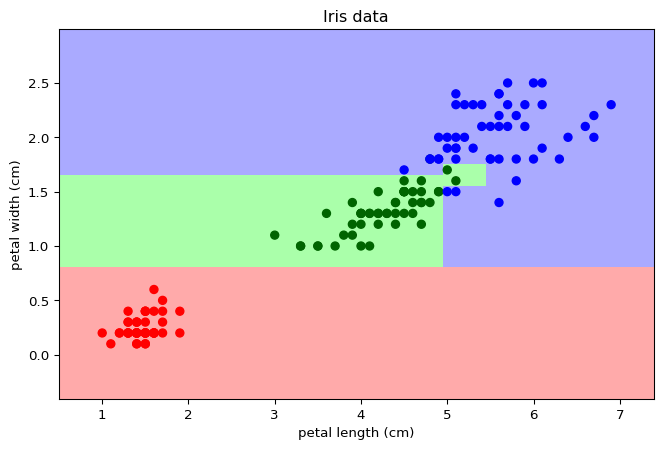

In [ ]:
from sklearn.tree import DecisionTreeClassifier

sklearn_tree = DecisionTreeClassifier(
    min_samples_split=2, max_depth=10, random_state=0
).fit(X, y)
plot_data(X, y, model=sklearn_tree, plot_boundaries=True)

Finally, let's compare the two implementations in terms of training time and accuracy:

In [ ]:
my_tree = MyDecisionTreeClassifier(min_samples_split=2, max_depth=10)
sklearn_tree = DecisionTreeClassifier(min_samples_split=2, max_depth=10)

print("my_tree")
%time my_tree.fit(X, y)
y_pred = my_tree.predict(X)
print(f"Train accuracy: {np.mean(y_pred == y)}\n")

print("sklearn_tree")
%time sklearn_tree.fit(X, y)
y_pred = sklearn_tree.predict(X)
print(f"Train accuracy: {np.mean(y_pred == y)}")

my_tree
CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 12.6 ms
Train accuracy: 0.9933333333333333

sklearn_tree
CPU times: user 1.38 ms, sys: 69 µs, total: 1.45 ms
Wall time: 1.38 ms
Train accuracy: 0.9933333333333333


As expected, [scikit-learn implementation](https://github.com/scikit-learn/scikit-learn/blob/89d66b39a0949c01beee5eb9739e192b8bcac7bd/sklearn/tree/_tree.pyx#L490) is several times faster, as it is highly optimized and written in [Cython](https://cython.org/) (a compiled version of Python).